In [1]:
from twitter_auth import bearer_token
import configparser
import tweepy
import time
import pandas as pd

config = configparser.ConfigParser()
config.read("config.ini")

api_key = config["twitter"]["api_key"]
api_key_secret = config["twitter"]["api_Key_secret"]

client = tweepy.Client(bearer_token, wait_on_rate_limit=True)

access_token = config["twitter"]["access_token"]
access_token_secret = config["twitter"]["access_Token_Secret"]

auth = tweepy.OAuth1UserHandler(api_key, api_key_secret)
auth.set_access_token(access_token, access_token_secret)

api = tweepy.API(auth)

try:
    api.verify_credentials()
    print("Successful Authentication")
except:
    print("Failed authentication")


Successful Authentication


In [2]:
tweets = []

for response in tweepy.Paginator(
    client.search_all_tweets,
    query="veteran #ptsd -is:retweet lang:en",
    user_fields=["username", "location"],
    tweet_fields=["created_at", "geo", "text"],
    expansions="author_id",
    start_time="2007-01-01T00:00:00Z",
    end_time="2022-11-17T00:00:00Z",
    max_results=500,
    limit=250000,
):
    time.sleep(1)
    tweets.append(response)


In [3]:
result = []
user_dict = {}
# Loop through each response object
for response in tweets:
    # Take all of the users, and put them into a dictionary of dictionaries with the info we want to keep
    for user in response.includes["users"]:
        user_dict[user.id] = {
            "username": user.username,
            "location": user.location,
        }
    for tweet in response.data:
        hashtags = []
        try:
            for hashtag in tweet.entities["hashtags"]:
                hashtags.append(hashtag["text"])
        except:
            pass
        # For each tweet, find the author's information
        author_info = user_dict[tweet.author_id]
        # Put all of the information we want to keep in a single dictionary for each tweet
        result.append(
            {
                "author_id": tweet.author_id,
                "username": author_info["username"],
                "author_location": author_info["location"],
                "text": tweet.text,
                "created_at": tweet.created_at,
                "hashtags": [hashtags if hashtags else None],
                "source": tweet.source,
            }
        )

# Change this list of dictionaries into a dataframe
df_tweets = pd.DataFrame(result)


In [4]:
df_tweets.to_csv("../data/ptsd_tweets.csv", index=False)
df_tweets = pd.read_csv("../data/ptsd_tweets.csv")
df_tweets.shape


(85349, 7)

In [5]:
df_tweets.head()


,author_id,username,author_location,text,created_at,hashtags,source
0,287091362,Infographics4u,NaN,How Does #PTSD Affect A #Veterans Life? https:...,2022-11-16 22:30:09+00:00,[None],NaN
1,462123325,rubyritz1,nyc,@dr_seminnis @libradunn i guess because of Vet...,2022-11-16 21:33:01+00:00,[None],NaN
2,385737100,InsaneLymeBrain,Texas,Have you ever seen a grown #veteran shit himse...,2022-11-16 21:10:08+00:00,[None],NaN
3,1558278739485655041,TallyMan_USMC,"Houston, TX","Listen to ""Episode 73 | US Marine Veteran Bria...",2022-11-16 21:00:58+00:00,[None],NaN
4,1592155263674744832,oldschoolethos,NaN,VETS Sara Wilkinson Veteran Psychedelic Therap...,2022-11-16 20:11:14+00:00,[None],NaN


In [6]:
df_tweets["author_location"].unique()


array([nan, 'nyc', 'Texas', ..., 'Southern, Indiana', 'Kennesaw GA',
       'Oceanside, CA, USA'], dtype=object)

In [7]:
df_tweets.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85349 entries, 0 to 85348
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   author_id        85349 non-null  int64  
 1   username         85349 non-null  object 
 2   author_location  77089 non-null  object 
 3   text             85349 non-null  object 
 4   created_at       85349 non-null  object 
 5   hashtags         85349 non-null  object 
 6   source           0 non-null      float64
dtypes: float64(1), int64(1), object(5)
memory usage: 4.6+ MB


## Lexicon based sentiment analysis

The majority of issues in real-world practise are caused by unsupervised learning, which implies the labels (Positive/Negative) are absent. Sentiment Analysis, commonly referred to as Opinion Mining, is a branch of Natural Language Processing (NLP) that seeks to discover and extract views from texts by analysing the sentiments, attitudes, and emotions of the author.
Generally, there are 3 methods:

1. Methods based on rules
2. Methods based on features

3. Methods based on embedding

Methods that use a set of manually created criteria to determine subjectivity, polarity, or the focus of an opinion are known as rule-based approaches. Techniques like stemming, tokenization, part-of-speech tagging, parsing, and Lexicons are used in these (i.e. lists of words and expressions). Typically, two lists of polarised terms—one with negative words like awful, worst, and ugly, and the other with positive words like good, best, and beautiful—are created. We count the number of positive and negative terms in a given text. The algorithm returns a good attitude if there are more positive word appearances than negative word appearances, and vice versa. In the event if the numbers are even, the algorithm will produce a neutral result. Techniques include VADER and TextBlob

Rule-based systems tend to be naïve since they ignore the way that words are combined in a series. As a result, when sentiment analysis is framed as a classification issue, feature-based algorithms depending on ML techniques like SVM, Decision trees, etc. are employed. A bag-of-words or bag-of-ngrams approach with their frequency has been the traditional method for transforming the text extraction or text vectorization in a machine learning text classifier. Recently, novel feature extraction methods based on word embeddings have been used (also known as word vectors). The performance of classifiers can be enhanced by allowing words with similar meanings to have comparable representations thanks to this type of representations.

A vocabulary and rule-based sentiment analysis tool called Valence Aware Dictionary and sEntiment Reasoner excels in analysing social media sentiment. It responds to the strength (intensity) and polarity (positive/negative) of emotions. It may be used right away on unlabeled text data and is included in the NLTK package.


In [8]:
import plotly.figure_factory as ff
import plotly.express as px
from plotly import graph_objs as go
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import spacy
import re
import nltk
import string
import pandas as pd
import numpy as np
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from nltk.stem import PorterStemmer
nltk.download('vader_lexicon')
# For viz

%matplotlib inline
import torch
import urllib.request
torch.cuda.is_available()

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\ajaoo\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

## Cleaning Text

Text data cleaning is one of Natural Language Processing's (NLP) most frequent jobs. It's crucial to reduce your text to the most significant root terms in the corpus in order to optimise your findings. This post will demonstrate my regular method for doing this. The general phases in text preparation are as follows:

1. Tokenization divides the text into smaller parts rather than long blocks of text. These units are comprehended by humans as words or phrases, but machines cannot until they are divided. To form logical units, special attention must be given while breaking words down. Although most software programmes can manage edge scenarios (e.g., the US broke into the US and not U and S), accuracy is always crucial.
2. Cleaning is essential for getting rid of text and characters that are irrelevant to the study. Deleted text includes URLs, noncritical characters like hyphens or special characters, web scraping, HTML, and CSS data.
3. The procedure of eliminating stop words is the next step. Stop words are frequent words that are used but offer nothing to the conversation. Examples include the word "a" and the word "the." Additionally, these terms regularly arise, take over your analysis, and mask the important words.

4. Spelling corrections are also possible when doing the analysis. There may be more or fewer mistakes, depending on the communication channel. While social media postings or more casual interactions like email might have more faults, official corporate or educational materials most likely have less. Correcting spelling problems or not is a crucial stage depends on the desired goal.

5. Lemmatization is the process of reducing a word to its stem by deleting letters from the beginning or end of the word. When "runs" is reduced to "run" as the base word by eliminating the "s," stemming has taken place, even if "ran" is not in the same stem. Lemmatization, however, would include "ran" in the same lemma.


In [9]:
stopword = nltk.corpus.stopwords.words('english')
ps = nltk.PorterStemmer()
wn = nltk.WordNetLemmatizer()
def remove_punct(text):
    text  = "".join([char for char in text if char not in string.punctuation])
    text = re.sub('[0-9]+', '', text)
    return text

def tokenization(text):
    text = re.split('\W+', text)
    return text

def remove_stopwords(text):
    text = [word for word in text if word not in stopword]
    return text
    


def stemming(text):
    text = [ps.stem(word) for word in text]
    return text



def lemmatizer(text):
    text = [wn.lemmatize(word) for word in text]
    return text

def clean_text(text):
    text_lc = "".join([word.lower() for word in text if word not in string.punctuation]) # remove puntuation
    text_rc = re.sub('[0-9]+', '', text_lc)
    tokens = re.split('\W+', text_rc)    # tokenization
    text = [ps.stem(word) for word in tokens if word not in stopword]  # remove stopwords and stemming
    return text

In [10]:
# def clean_txt(tweet):
#     tweet  = "".join([char for char in tweet if char not in string.punctuation])
#     tweet = tweet.translate(str.maketrans('', '', string.punctuation)) #strip punctuation
#     # Remove stop words
#     tweet = tweet.split()
#     useless_words = nltk.corpus.stopwords.words("english")
#     tweet = [word for word in tweet if not word in useless_words]
#     tweet = re.sub('[0-9]+', '', tweet)
#     tweet = re.sub('RT', '', tweet)
#     tweet = tweet.lower() #to lowercase
#     return tweet


In [11]:
data = pd.read_csv("../data/ptsd_tweets.csv")
data.shape


(85349, 7)

In [12]:
# Clean and select text
df = pd.DataFrame(np.array(data["text"]), columns=["text"])


In [13]:
df['Tweet_punct'] = df['text'].apply(lambda x: remove_punct(x))
df.head(10)

,text,Tweet_punct
0,How Does #PTSD Affect A #Veterans Life? https:...,How Does PTSD Affect A Veterans Life httpstcou...
1,@dr_seminnis @libradunn i guess because of Vet...,drseminnis libradunn i guess because of Vetera...
2,Have you ever seen a grown #veteran shit himse...,Have you ever seen a grown veteran shit himsel...
3,"Listen to ""Episode 73 | US Marine Veteran Bria...",Listen to Episode US Marine Veteran Brian Ba...
4,VETS Sara Wilkinson Veteran Psychedelic Therap...,VETS Sara Wilkinson Veteran Psychedelic Therap...
5,Marcus &amp; Amber Capone Psychedelic Therapy....,Marcus amp Amber Capone Psychedelic Therapy Th...
6,Psychedelics Marcus &amp; Amber Capone Jocko P...,Psychedelics Marcus amp Amber Capone Jocko Pod...
7,Team Never Quit TNQ Podcasts Marcus Amber Capo...,Team Never Quit TNQ Podcasts Marcus Amber Capo...
8,"""Dancer &amp; Other Tattered Threads of #PTSD ...",Dancer amp Other Tattered Threads of PTSD Live...
9,@Militarydotcom We need to do better for Veter...,Militarydotcom We need to do better for Vetera...


In [14]:
df['Tweet_tokenized'] = df['Tweet_punct'].apply(lambda x: tokenization(x.lower()))
df.head()

,text,Tweet_punct,Tweet_tokenized
0,How Does #PTSD Affect A #Veterans Life? https:...,How Does PTSD Affect A Veterans Life httpstcou...,"[how, does, ptsd, affect, a, veterans, life, h..."
1,@dr_seminnis @libradunn i guess because of Vet...,drseminnis libradunn i guess because of Vetera...,"[drseminnis, libradunn, i, guess, because, of,..."
2,Have you ever seen a grown #veteran shit himse...,Have you ever seen a grown veteran shit himsel...,"[have, you, ever, seen, a, grown, veteran, shi..."
3,"Listen to ""Episode 73 | US Marine Veteran Bria...",Listen to Episode US Marine Veteran Brian Ba...,"[listen, to, episode, us, marine, veteran, bri..."
4,VETS Sara Wilkinson Veteran Psychedelic Therap...,VETS Sara Wilkinson Veteran Psychedelic Therap...,"[vets, sara, wilkinson, veteran, psychedelic, ..."


In [15]:
df['Tweet_nonstop'] = df['Tweet_tokenized'].apply(lambda x: remove_stopwords(x))
df.head(10)

,text,Tweet_punct,Tweet_tokenized,Tweet_nonstop
0,How Does #PTSD Affect A #Veterans Life? https:...,How Does PTSD Affect A Veterans Life httpstcou...,"[how, does, ptsd, affect, a, veterans, life, h...","[ptsd, affect, veterans, life, httpstcouvtqawc..."
1,@dr_seminnis @libradunn i guess because of Vet...,drseminnis libradunn i guess because of Vetera...,"[drseminnis, libradunn, i, guess, because, of,...","[drseminnis, libradunn, guess, veterans, day, ..."
2,Have you ever seen a grown #veteran shit himse...,Have you ever seen a grown veteran shit himsel...,"[have, you, ever, seen, a, grown, veteran, shi...","[ever, seen, grown, veteran, shit, car, sick, ..."
3,"Listen to ""Episode 73 | US Marine Veteran Bria...",Listen to Episode US Marine Veteran Brian Ba...,"[listen, to, episode, us, marine, veteran, bri...","[listen, episode, us, marine, veteran, brian, ..."
4,VETS Sara Wilkinson Veteran Psychedelic Therap...,VETS Sara Wilkinson Veteran Psychedelic Therap...,"[vets, sara, wilkinson, veteran, psychedelic, ...","[vets, sara, wilkinson, veteran, psychedelic, ..."
5,Marcus &amp; Amber Capone Psychedelic Therapy....,Marcus amp Amber Capone Psychedelic Therapy Th...,"[marcus, amp, amber, capone, psychedelic, ther...","[marcus, amp, amber, capone, psychedelic, ther..."
6,Psychedelics Marcus &amp; Amber Capone Jocko P...,Psychedelics Marcus amp Amber Capone Jocko Pod...,"[psychedelics, marcus, amp, amber, capone, joc...","[psychedelics, marcus, amp, amber, capone, joc..."
7,Team Never Quit TNQ Podcasts Marcus Amber Capo...,Team Never Quit TNQ Podcasts Marcus Amber Capo...,"[team, never, quit, tnq, podcasts, marcus, amb...","[team, never, quit, tnq, podcasts, marcus, amb..."
8,"""Dancer &amp; Other Tattered Threads of #PTSD ...",Dancer amp Other Tattered Threads of PTSD Live...,"[dancer, amp, other, tattered, threads, of, pt...","[dancer, amp, tattered, threads, ptsd, lives, ..."
9,@Militarydotcom We need to do better for Veter...,Militarydotcom We need to do better for Vetera...,"[militarydotcom, we, need, to, do, better, for...","[militarydotcom, need, better, veterans, thoug..."


In [16]:
df['Tweet_stemmed'] = df['Tweet_nonstop'].apply(lambda x: stemming(x))
df.head()

,text,Tweet_punct,Tweet_tokenized,Tweet_nonstop,Tweet_stemmed
0,How Does #PTSD Affect A #Veterans Life? https:...,How Does PTSD Affect A Veterans Life httpstcou...,"[how, does, ptsd, affect, a, veterans, life, h...","[ptsd, affect, veterans, life, httpstcouvtqawc...","[ptsd, affect, veteran, life, httpstcouvtqawcw..."
1,@dr_seminnis @libradunn i guess because of Vet...,drseminnis libradunn i guess because of Vetera...,"[drseminnis, libradunn, i, guess, because, of,...","[drseminnis, libradunn, guess, veterans, day, ...","[drseminni, libradunn, guess, veteran, day, re..."
2,Have you ever seen a grown #veteran shit himse...,Have you ever seen a grown veteran shit himsel...,"[have, you, ever, seen, a, grown, veteran, shi...","[ever, seen, grown, veteran, shit, car, sick, ...","[ever, seen, grown, veteran, shit, car, sick, ..."
3,"Listen to ""Episode 73 | US Marine Veteran Bria...",Listen to Episode US Marine Veteran Brian Ba...,"[listen, to, episode, us, marine, veteran, bri...","[listen, episode, us, marine, veteran, brian, ...","[listen, episod, us, marin, veteran, brian, ba..."
4,VETS Sara Wilkinson Veteran Psychedelic Therap...,VETS Sara Wilkinson Veteran Psychedelic Therap...,"[vets, sara, wilkinson, veteran, psychedelic, ...","[vets, sara, wilkinson, veteran, psychedelic, ...","[vet, sara, wilkinson, veteran, psychedel, the..."


In [17]:
df['Tweet_lemmatized'] = df['Tweet_nonstop'].apply(lambda x: lemmatizer(x))
df.head()

,text,Tweet_punct,Tweet_tokenized,Tweet_nonstop,Tweet_stemmed,Tweet_lemmatized
0,How Does #PTSD Affect A #Veterans Life? https:...,How Does PTSD Affect A Veterans Life httpstcou...,"[how, does, ptsd, affect, a, veterans, life, h...","[ptsd, affect, veterans, life, httpstcouvtqawc...","[ptsd, affect, veteran, life, httpstcouvtqawcw...","[ptsd, affect, veteran, life, httpstcouvtqawcw..."
1,@dr_seminnis @libradunn i guess because of Vet...,drseminnis libradunn i guess because of Vetera...,"[drseminnis, libradunn, i, guess, because, of,...","[drseminnis, libradunn, guess, veterans, day, ...","[drseminni, libradunn, guess, veteran, day, re...","[drseminnis, libradunn, guess, veteran, day, r..."
2,Have you ever seen a grown #veteran shit himse...,Have you ever seen a grown veteran shit himsel...,"[have, you, ever, seen, a, grown, veteran, shi...","[ever, seen, grown, veteran, shit, car, sick, ...","[ever, seen, grown, veteran, shit, car, sick, ...","[ever, seen, grown, veteran, shit, car, sick, ..."
3,"Listen to ""Episode 73 | US Marine Veteran Bria...",Listen to Episode US Marine Veteran Brian Ba...,"[listen, to, episode, us, marine, veteran, bri...","[listen, episode, us, marine, veteran, brian, ...","[listen, episod, us, marin, veteran, brian, ba...","[listen, episode, u, marine, veteran, brian, b..."
4,VETS Sara Wilkinson Veteran Psychedelic Therap...,VETS Sara Wilkinson Veteran Psychedelic Therap...,"[vets, sara, wilkinson, veteran, psychedelic, ...","[vets, sara, wilkinson, veteran, psychedelic, ...","[vet, sara, wilkinson, veteran, psychedel, the...","[vet, sara, wilkinson, veteran, psychedelic, t..."


In [18]:
# pip install -U spacy
# python -m spacy download en_core_web_sm
# Load spacy
nlp = spacy.load('en_core_web_sm')


def clean_string(text, stem="None"):

    final_string = ""

    # Make lower
    text = text.lower()

    # Remove line breaks
    text = re.sub(r'\n', '', text)

    # Remove puncuation
    translator = str.maketrans('', '', string.punctuation)
    text = text.translate(translator)

    # Remove stop words
    text = text.split()
    useless_words = nltk.corpus.stopwords.words("english")
    useless_words = useless_words + ['rt', 'via', 'amp', 'https', 'co', 'http']
    text_filtered = [word for word in text if not word in useless_words]

    # Remove numbers
    text_filtered = [re.sub('[0-9]+', '', w) for w in text_filtered]

    # Stem or Lemmatize
    if stem == 'Stem':
        stemmer = PorterStemmer()
        text_stemmed = [stemmer.stem(y) for y in text_filtered]
    elif stem == 'Lem':
        lem = WordNetLemmatizer()
        text_stemmed = [lem.lemmatize(y) for y in text_filtered]
    elif stem == 'Spacy':
        text_filtered = nlp(' '.join(text_filtered))
        text_stemmed = [y.lemma_ for y in text_filtered]
    else:
        text_stemmed = text_filtered

    final_string = ' '.join(text_stemmed)

    return final_string

In [19]:
df['text'] = df['text'].apply(lambda x: clean_string(x, stem='Stem'))
df.head()


,text,Tweet_punct,Tweet_tokenized,Tweet_nonstop,Tweet_stemmed,Tweet_lemmatized
0,ptsd affect veteran life httpstcouvtqawcwib ht...,How Does PTSD Affect A Veterans Life httpstcou...,"[how, does, ptsd, affect, a, veterans, life, h...","[ptsd, affect, veterans, life, httpstcouvtqawc...","[ptsd, affect, veteran, life, httpstcouvtqawcw...","[ptsd, affect, veteran, life, httpstcouvtqawcw..."
1,drseminni libradunn guess veteran day recent d...,drseminnis libradunn i guess because of Vetera...,"[drseminnis, libradunn, i, guess, because, of,...","[drseminnis, libradunn, guess, veterans, day, ...","[drseminni, libradunn, guess, veteran, day, re...","[drseminnis, libradunn, guess, veteran, day, r..."
2,ever seen grown veteran shit car he’ sick bowe...,Have you ever seen a grown veteran shit himsel...,"[have, you, ever, seen, a, grown, veteran, shi...","[ever, seen, grown, veteran, shit, car, sick, ...","[ever, seen, grown, veteran, shit, car, sick, ...","[ever, seen, grown, veteran, shit, car, sick, ..."
3,listen episod us marin veteran brian barber s...,Listen to Episode US Marine Veteran Brian Ba...,"[listen, to, episode, us, marine, veteran, bri...","[listen, episode, us, marine, veteran, brian, ...","[listen, episod, us, marin, veteran, brian, ba...","[listen, episode, u, marine, veteran, brian, b..."
4,vet sara wilkinson veteran psychedel therapi p...,VETS Sara Wilkinson Veteran Psychedelic Therap...,"[vets, sara, wilkinson, veteran, psychedelic, ...","[vets, sara, wilkinson, veteran, psychedelic, ...","[vet, sara, wilkinson, veteran, psychedel, the...","[vet, sara, wilkinson, veteran, psychedelic, t..."


In [20]:
from nltk.tokenize import RegexpTokenizer
tokenizer = RegexpTokenizer(r'\w+')
words_descriptions = df['text'].apply(tokenizer.tokenize)
words_descriptions.head()


0    [ptsd, affect, veteran, life, httpstcouvtqawcw...
1    [drseminni, libradunn, guess, veteran, day, re...
2    [ever, seen, grown, veteran, shit, car, he, si...
3    [listen, episod, us, marin, veteran, brian, ba...
4    [vet, sara, wilkinson, veteran, psychedel, the...
Name: text, dtype: object

In [21]:
all_words = [word for tokens in words_descriptions for word in tokens]
df['description_lengths'] = [len(tokens) for tokens in words_descriptions]
VOCAB = sorted(list(set(all_words)))
print("%s words total, with a vocabulary size of %s" %
      (len(all_words), len(VOCAB)))


1369095 words total, with a vocabulary size of 129925


In [22]:
# Checking most common words
from collections import Counter
count_all_words = Counter(all_words)
count_all_words.most_common(100)


[('veteran', 92530),
 ('ptsd', 87538),
 ('pleas', 23531),
 ('help', 23496),
 ('support', 16540),
 ('would', 13858),
 ('mentalhealth', 12971),
 ('long', 12286),
 ('show', 11636),
 ('itsoknottobeok', 11382),
 ('donat', 11204),
 ('war', 10338),
 ('share', 9976),
 ('armi', 9171),
 ('militari', 8960),
 ('mentalhealthawar', 8582),
 ('suffer', 8554),
 ('mental', 7709),
 ('stori', 7324),
 ('go', 7239),
 ('bracelet', 7220),
 ('may', 6736),
 ('still', 6658),
 ('vietnam', 6590),
 ('read', 6542),
 ('small', 6510),
 ('physic', 6422),
 ('appreci', 6328),
 ('push', 6255),
 ('scar', 6198),
 ('remainpleas', 5932),
 ('suicid', 5498),
 ('handmad', 5471),
 ('hero', 5323),
 ('storyth', 5144),
 ('paracord', 4936),
 ('marijuana', 4859),
 ('book', 4825),
 ('anyon', 4658),
 ('vet', 4606),
 ('tbi', 4584),
 ('daughter', 4577),
 ('contact', 4197),
 ('wayhttpstcohffntzmejparmi', 4149),
 ('tribut', 4038),
 ('interest', 3989),
 ('dog', 3890),
 ('soldier', 3862),
 ('live', 3858),
 ('made', 3801),
 ('detail', 3762),
 

In [23]:
analyser = SentimentIntensityAnalyzer()
df['scores'] = df['text'].apply(
    lambda review: analyser.polarity_scores(review))

df.head()


,text,Tweet_punct,Tweet_tokenized,Tweet_nonstop,Tweet_stemmed,Tweet_lemmatized,description_lengths,scores
0,ptsd affect veteran life httpstcouvtqawcwib ht...,How Does PTSD Affect A Veterans Life httpstcou...,"[how, does, ptsd, affect, a, veterans, life, h...","[ptsd, affect, veterans, life, httpstcouvtqawc...","[ptsd, affect, veteran, life, httpstcouvtqawcw...","[ptsd, affect, veteran, life, httpstcouvtqawcw...",6,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound..."
1,drseminni libradunn guess veteran day recent d...,drseminnis libradunn i guess because of Vetera...,"[drseminnis, libradunn, i, guess, because, of,...","[drseminnis, libradunn, guess, veterans, day, ...","[drseminni, libradunn, guess, veteran, day, re...","[drseminnis, libradunn, guess, veteran, day, r...",25,"{'neg': 0.191, 'neu': 0.643, 'pos': 0.166, 'co..."
2,ever seen grown veteran shit car he’ sick bowe...,Have you ever seen a grown veteran shit himsel...,"[have, you, ever, seen, a, grown, veteran, shi...","[ever, seen, grown, veteran, shit, car, sick, ...","[ever, seen, grown, veteran, shit, car, sick, ...","[ever, seen, grown, veteran, shit, car, sick, ...",26,"{'neg': 0.342, 'neu': 0.658, 'pos': 0.0, 'comp..."
3,listen episod us marin veteran brian barber s...,Listen to Episode US Marine Veteran Brian Ba...,"[listen, to, episode, us, marine, veteran, bri...","[listen, episode, us, marine, veteran, brian, ...","[listen, episod, us, marin, veteran, brian, ba...","[listen, episode, u, marine, veteran, brian, b...",28,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound..."
4,vet sara wilkinson veteran psychedel therapi p...,VETS Sara Wilkinson Veteran Psychedelic Therap...,"[vets, sara, wilkinson, veteran, psychedelic, ...","[vets, sara, wilkinson, veteran, psychedelic, ...","[vet, sara, wilkinson, veteran, psychedel, the...","[vet, sara, wilkinson, veteran, psychedelic, t...",21,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound..."


Here, the terms neg (negative), neu (neutral), and pos (positive) designate the amounts of text that fit into each category; these amounts always add up to 1 (for example, 0.656 + 0.344 in the first tweet).
The entire score is represented by the compound score. It is the average of all lexical assessments, which are scaled from -1 (the most extreme negative) to +1. (most extreme poistive). The common criteria used to categorise sentences as positive, negative, or neutral are as follows:

1. Compound score >= 0.05 for favourable emotion
2. Positive and negative sentiment (compound scores > -0.05)
   Compound score = -0.05 for unfavourable emotion.
   According to the needs, they can be modified for courses that are extremely positive, positive, neutral, negative, and highly negative.
   Emojis, slang terms (abbreviations), emoticons, punctuation, and other text analysis preprocessing are not necessary because VADER calculates ratings based on them.


In [24]:
df['compound'] = df['scores'].apply(lambda score_dict: score_dict['compound'])

df.head()


,text,Tweet_punct,Tweet_tokenized,Tweet_nonstop,Tweet_stemmed,Tweet_lemmatized,description_lengths,scores,compound
0,ptsd affect veteran life httpstcouvtqawcwib ht...,How Does PTSD Affect A Veterans Life httpstcou...,"[how, does, ptsd, affect, a, veterans, life, h...","[ptsd, affect, veterans, life, httpstcouvtqawc...","[ptsd, affect, veteran, life, httpstcouvtqawcw...","[ptsd, affect, veteran, life, httpstcouvtqawcw...",6,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000
1,drseminni libradunn guess veteran day recent d...,drseminnis libradunn i guess because of Vetera...,"[drseminnis, libradunn, i, guess, because, of,...","[drseminnis, libradunn, guess, veterans, day, ...","[drseminni, libradunn, guess, veteran, day, re...","[drseminnis, libradunn, guess, veteran, day, r...",25,"{'neg': 0.191, 'neu': 0.643, 'pos': 0.166, 'co...",-0.2094
2,ever seen grown veteran shit car he’ sick bowe...,Have you ever seen a grown veteran shit himsel...,"[have, you, ever, seen, a, grown, veteran, shi...","[ever, seen, grown, veteran, shit, car, sick, ...","[ever, seen, grown, veteran, shit, car, sick, ...","[ever, seen, grown, veteran, shit, car, sick, ...",26,"{'neg': 0.342, 'neu': 0.658, 'pos': 0.0, 'comp...",-0.8860
3,listen episod us marin veteran brian barber s...,Listen to Episode US Marine Veteran Brian Ba...,"[listen, to, episode, us, marine, veteran, bri...","[listen, episode, us, marine, veteran, brian, ...","[listen, episod, us, marin, veteran, brian, ba...","[listen, episode, u, marine, veteran, brian, b...",28,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000
4,vet sara wilkinson veteran psychedel therapi p...,VETS Sara Wilkinson Veteran Psychedelic Therap...,"[vets, sara, wilkinson, veteran, psychedelic, ...","[vets, sara, wilkinson, veteran, psychedelic, ...","[vet, sara, wilkinson, veteran, psychedel, the...","[vet, sara, wilkinson, veteran, psychedelic, t...",21,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000


In [25]:
def Sentiment(x):
    if x >= 0.05:
        return "Positive"
    elif x <= -0.05:
        return "Negative"
    else:
        return "Neutral"


df['Sentiment'] = df['compound'].apply(Sentiment)


df.head()


,text,Tweet_punct,Tweet_tokenized,Tweet_nonstop,Tweet_stemmed,Tweet_lemmatized,description_lengths,scores,compound,Sentiment
0,ptsd affect veteran life httpstcouvtqawcwib ht...,How Does PTSD Affect A Veterans Life httpstcou...,"[how, does, ptsd, affect, a, veterans, life, h...","[ptsd, affect, veterans, life, httpstcouvtqawc...","[ptsd, affect, veteran, life, httpstcouvtqawcw...","[ptsd, affect, veteran, life, httpstcouvtqawcw...",6,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,Neutral
1,drseminni libradunn guess veteran day recent d...,drseminnis libradunn i guess because of Vetera...,"[drseminnis, libradunn, i, guess, because, of,...","[drseminnis, libradunn, guess, veterans, day, ...","[drseminni, libradunn, guess, veteran, day, re...","[drseminnis, libradunn, guess, veteran, day, r...",25,"{'neg': 0.191, 'neu': 0.643, 'pos': 0.166, 'co...",-0.2094,Negative
2,ever seen grown veteran shit car he’ sick bowe...,Have you ever seen a grown veteran shit himsel...,"[have, you, ever, seen, a, grown, veteran, shi...","[ever, seen, grown, veteran, shit, car, sick, ...","[ever, seen, grown, veteran, shit, car, sick, ...","[ever, seen, grown, veteran, shit, car, sick, ...",26,"{'neg': 0.342, 'neu': 0.658, 'pos': 0.0, 'comp...",-0.8860,Negative
3,listen episod us marin veteran brian barber s...,Listen to Episode US Marine Veteran Brian Ba...,"[listen, to, episode, us, marine, veteran, bri...","[listen, episode, us, marine, veteran, brian, ...","[listen, episod, us, marin, veteran, brian, ba...","[listen, episode, u, marine, veteran, brian, b...",28,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,Neutral
4,vet sara wilkinson veteran psychedel therapi p...,VETS Sara Wilkinson Veteran Psychedelic Therap...,"[vets, sara, wilkinson, veteran, psychedelic, ...","[vets, sara, wilkinson, veteran, psychedelic, ...","[vet, sara, wilkinson, veteran, psychedel, the...","[vet, sara, wilkinson, veteran, psychedelic, t...",21,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,Neutral


In [26]:
df = df.reset_index().rename(columns={'index': 'Id'})
df.head()

,Id,text,Tweet_punct,Tweet_tokenized,Tweet_nonstop,Tweet_stemmed,Tweet_lemmatized,description_lengths,scores,compound,Sentiment
0,0,ptsd affect veteran life httpstcouvtqawcwib ht...,How Does PTSD Affect A Veterans Life httpstcou...,"[how, does, ptsd, affect, a, veterans, life, h...","[ptsd, affect, veterans, life, httpstcouvtqawc...","[ptsd, affect, veteran, life, httpstcouvtqawcw...","[ptsd, affect, veteran, life, httpstcouvtqawcw...",6,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,Neutral
1,1,drseminni libradunn guess veteran day recent d...,drseminnis libradunn i guess because of Vetera...,"[drseminnis, libradunn, i, guess, because, of,...","[drseminnis, libradunn, guess, veterans, day, ...","[drseminni, libradunn, guess, veteran, day, re...","[drseminnis, libradunn, guess, veteran, day, r...",25,"{'neg': 0.191, 'neu': 0.643, 'pos': 0.166, 'co...",-0.2094,Negative
2,2,ever seen grown veteran shit car he’ sick bowe...,Have you ever seen a grown veteran shit himsel...,"[have, you, ever, seen, a, grown, veteran, shi...","[ever, seen, grown, veteran, shit, car, sick, ...","[ever, seen, grown, veteran, shit, car, sick, ...","[ever, seen, grown, veteran, shit, car, sick, ...",26,"{'neg': 0.342, 'neu': 0.658, 'pos': 0.0, 'comp...",-0.8860,Negative
3,3,listen episod us marin veteran brian barber s...,Listen to Episode US Marine Veteran Brian Ba...,"[listen, to, episode, us, marine, veteran, bri...","[listen, episode, us, marine, veteran, brian, ...","[listen, episod, us, marin, veteran, brian, ba...","[listen, episode, u, marine, veteran, brian, b...",28,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,Neutral
4,4,vet sara wilkinson veteran psychedel therapi p...,VETS Sara Wilkinson Veteran Psychedelic Therap...,"[vets, sara, wilkinson, veteran, psychedelic, ...","[vets, sara, wilkinson, veteran, psychedelic, ...","[vet, sara, wilkinson, veteran, psychedel, the...","[vet, sara, wilkinson, veteran, psychedelic, t...",21,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,Neutral


In [27]:
var1 = df.groupby('Sentiment').count()['text'].reset_index(
).sort_values(by='text', ascending=False)
sns.set_style("white")
sns.set_palette("Set2")
var1.style.background_gradient()


,Sentiment,text
2,Positive,46603
0,Negative,19622
1,Neutral,19124


Text(0.5, 1.0, 'Sentiment Analysis Result on VADER model')

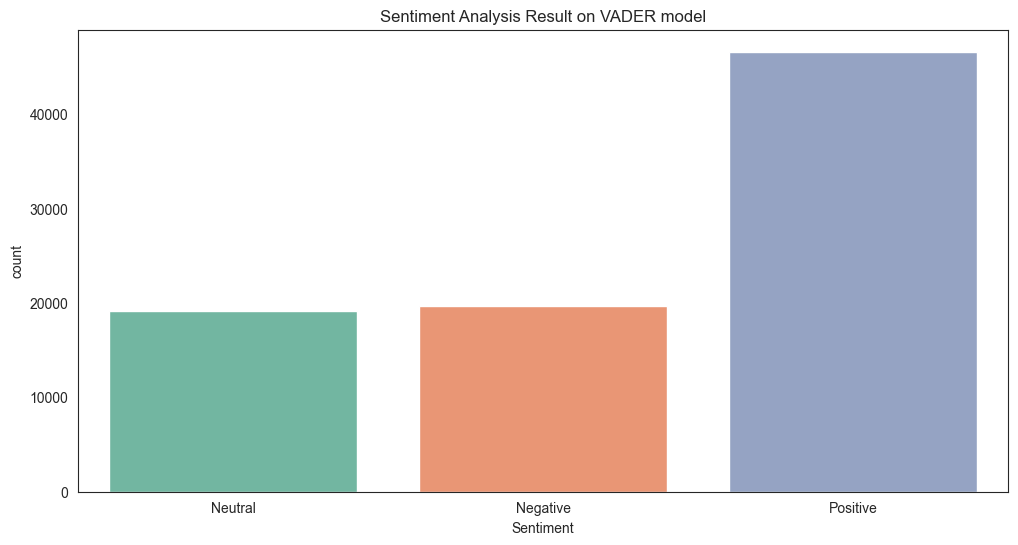

In [28]:
plt.figure(figsize=(12, 6))
sns.countplot(x='Sentiment', data=df)
plt.title('Sentiment Analysis Result on VADER model')

In [29]:
fig = go.Figure(go.Funnelarea(
    text=var1.Sentiment,
    values=var1.text,
    title={"position": "top center",
           "text": "Funnel-Chart of Sentiment Distribution"}
))
fig.show()


In [30]:
# most common words
df['temp_list'] = df['text'].apply(lambda x: str(x).split())
top = Counter([item for sublist in df['temp_list'] for item in sublist])
temp = pd.DataFrame(top.most_common(20))
temp.columns = ['Common_words', 'count']


In [31]:
fig = px.bar(temp, x="count", y="Common_words", title='Commmon Words in Selected Text', orientation='h',
             width=700, height=700, color='Common_words')
fig.show()


In [32]:
# Tree of the most common words
fig = px.treemap(temp, path=['Common_words'],
                 values='count', title='Tree of Most Common Words')
fig.show()


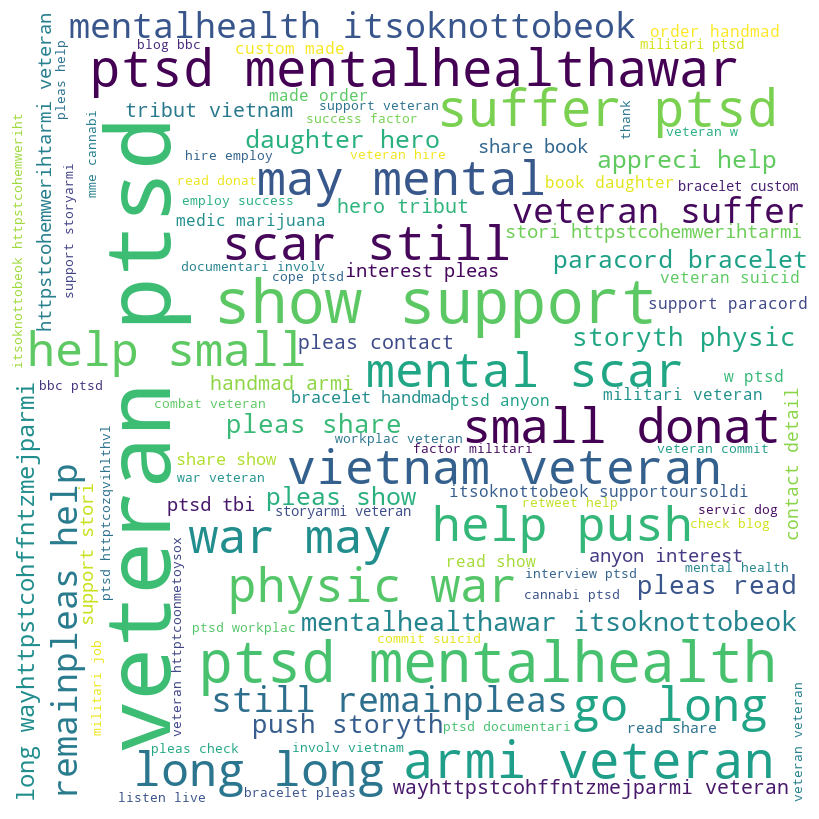

In [33]:
comment_words = ''
stopwords = set(STOPWORDS)

# iterate through the csv file
for val in df.text:

    # typecaste each val to string
    val = str(val)

    # split the value
    tokens = val.split()

    # Converts each token into lowercase
    for i in range(len(tokens)):
        tokens[i] = tokens[i].lower()

    comment_words += " ".join(tokens)+" "

wordcloud = WordCloud(width=800, height=800,
                      background_color='white',
                      stopwords=stopwords,
                      min_font_size=10).generate(comment_words)

# plot the WordCloud image
plt.figure(figsize=(8, 8), facecolor=None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)

plt.show()


In [34]:
def wordCloud_plot(sentiment, color):
    comment_words = ''
    stopwords = set(STOPWORDS)

    df_positive = df[df["Sentiment"] == sentiment]
    # iterate through the csv file
    for val in df_positive.text:

        # typecaste each val to string
        val = str(val)

        # split the value
        tokens = val.split()

        # Converts each token into lowercase
        for i in range(len(tokens)):
            tokens[i] = tokens[i].lower()

        comment_words += " ".join(tokens)+" "

    wordcloud = WordCloud(width=800, height=800,
                          background_color='white',
                          stopwords=stopwords,
                          min_font_size=10).generate(comment_words)

    # plot the WordCloud image
    plt.figure(figsize=(8, 8), facecolor=color)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.tight_layout(pad=0)

    plt.show()


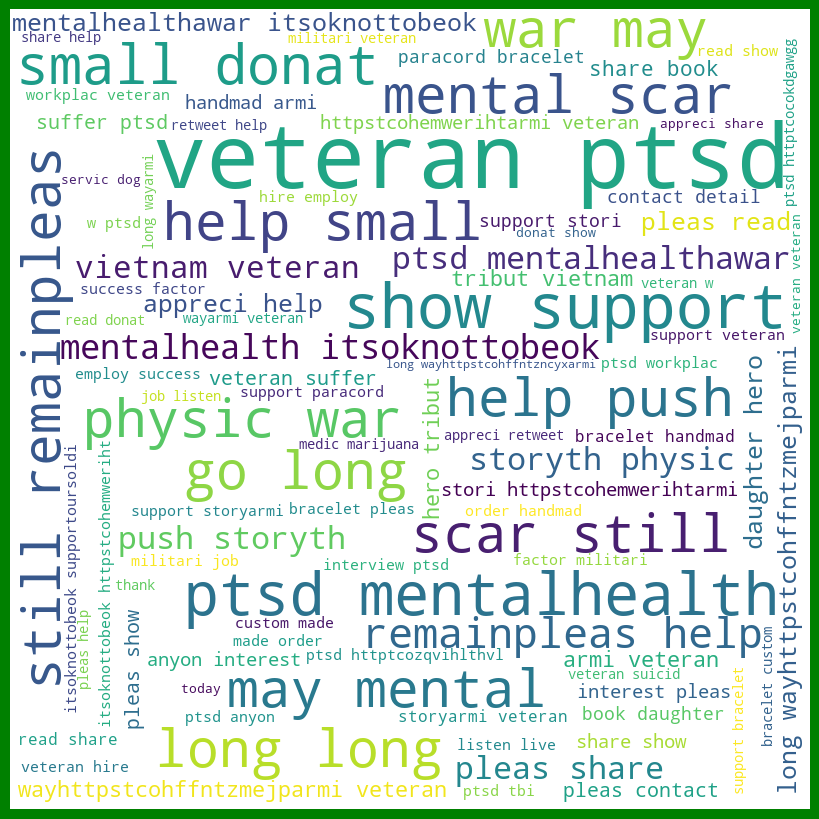

In [35]:
# positive word cloud
wordCloud_plot("Positive", "green")


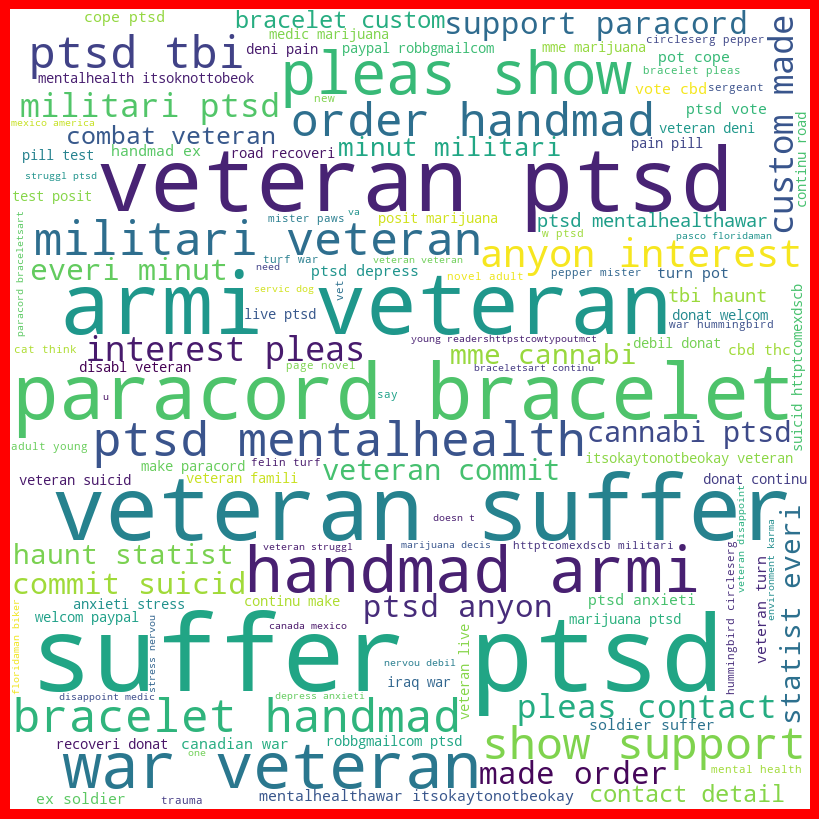

In [36]:
# negative word cloud
wordCloud_plot("Negative", "red")


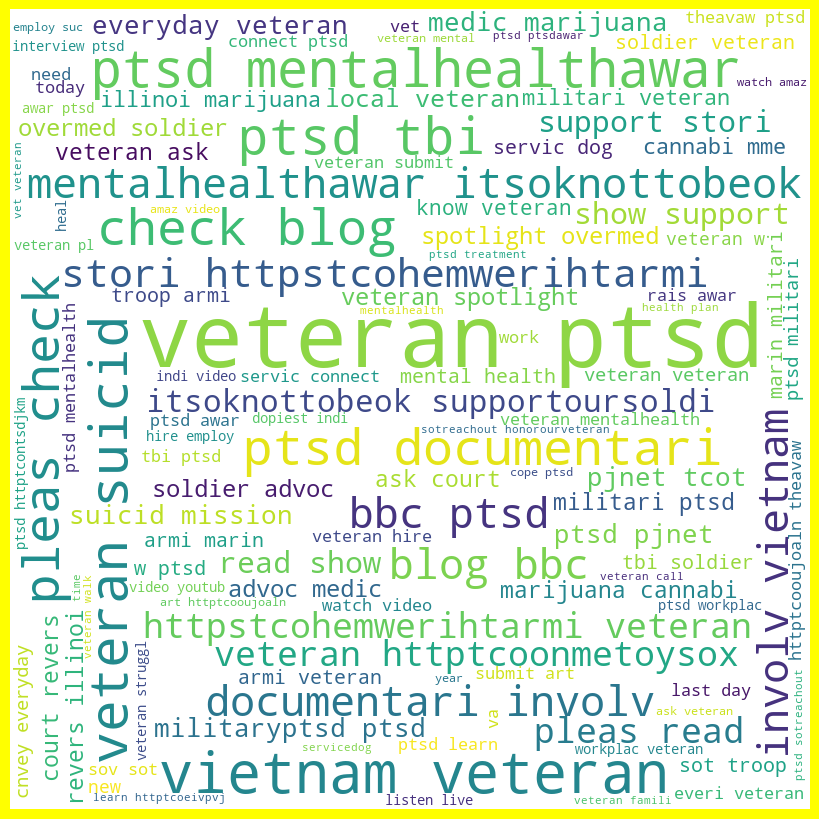

In [37]:
# neutral word cloud
wordCloud_plot("Neutral", "yellow")


## Roberta pretrained model 
it was trained on a large corpus of twitter data, transformer models accounts for the words but also the context related to other words. this is better for sentiment analysis than rule base

In [38]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from scipy.special import softmax
from tqdm.notebook import tqdm

In [39]:
task='sentiment'
MODEL = f"cardiffnlp/twitter-roberta-base-{task}"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

In [40]:
def polarity_scores_roberta(text):
    encoded_input = tokenizer(text, return_tensors='pt')
    output = model(**encoded_input)
    scores = output[0][0]
    scores = softmax(scores.detach().numpy())
    scores_dict = {
        'roberta_neg' : scores[0],
        'roberta_neu' : scores[1],
        'roberta_pos' : scores[2]
    }
    return scores_dict

In [41]:
res = {}

for i, row in tqdm(df.iterrows(), total=len(df)):
    try:
        text = row['text']
        myid = row['Id']
        vader_result = SentimentIntensityAnalyzer().polarity_scores(text)
        vader_result_rename = {}
        for key, value in vader_result.items():
            vader_result_rename[f"vader_{key}"] = value
        roberta_result = polarity_scores_roberta(text)
        both = {**vader_result_rename, **roberta_result}
        res[myid] = both
    except RuntimeError:
        print(f'Broke for id{myid}')

  0%|          | 0/85349 [00:00<?, ?it/s]

In [42]:
results_df = pd.DataFrame(res).T
results_df = results_df.reset_index().rename(columns={'index': 'Id'})
results_df = results_df.merge(df, on='Id')

In [43]:
results_df.head()

,Id,vader_neg,vader_neu,vader_pos,vader_compound,roberta_neg,roberta_neu,roberta_pos,text,Tweet_punct,Tweet_tokenized,Tweet_nonstop,Tweet_stemmed,Tweet_lemmatized,description_lengths,scores,compound,Sentiment,temp_list
0,0,0.000,1.000,0.000,0.0000,0.235011,0.733742,0.031247,ptsd affect veteran life httpstcouvtqawcwib ht...,How Does PTSD Affect A Veterans Life httpstcou...,"[how, does, ptsd, affect, a, veterans, life, h...","[ptsd, affect, veterans, life, httpstcouvtqawc...","[ptsd, affect, veteran, life, httpstcouvtqawcw...","[ptsd, affect, veteran, life, httpstcouvtqawcw...",6,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,Neutral,"[ptsd, affect, veteran, life, httpstcouvtqawcw..."
1,1,0.191,0.643,0.166,-0.2094,0.160595,0.800648,0.038757,drseminni libradunn guess veteran day recent d...,drseminnis libradunn i guess because of Vetera...,"[drseminnis, libradunn, i, guess, because, of,...","[drseminnis, libradunn, guess, veterans, day, ...","[drseminni, libradunn, guess, veteran, day, re...","[drseminnis, libradunn, guess, veteran, day, r...",25,"{'neg': 0.191, 'neu': 0.643, 'pos': 0.166, 'co...",-0.2094,Negative,"[drseminni, libradunn, guess, veteran, day, re..."
2,2,0.342,0.658,0.000,-0.8860,0.917322,0.074064,0.008614,ever seen grown veteran shit car he’ sick bowe...,Have you ever seen a grown veteran shit himsel...,"[have, you, ever, seen, a, grown, veteran, shi...","[ever, seen, grown, veteran, shit, car, sick, ...","[ever, seen, grown, veteran, shit, car, sick, ...","[ever, seen, grown, veteran, shit, car, sick, ...",26,"{'neg': 0.342, 'neu': 0.658, 'pos': 0.0, 'comp...",-0.8860,Negative,"[ever, seen, grown, veteran, shit, car, he’, s..."
3,3,0.000,1.000,0.000,0.0000,0.050045,0.893782,0.056173,listen episod us marin veteran brian barber s...,Listen to Episode US Marine Veteran Brian Ba...,"[listen, to, episode, us, marine, veteran, bri...","[listen, episode, us, marine, veteran, brian, ...","[listen, episod, us, marin, veteran, brian, ba...","[listen, episode, u, marine, veteran, brian, b...",28,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,Neutral,"[listen, episod, us, marin, veteran, brian, ba..."
4,4,0.000,1.000,0.000,0.0000,0.091775,0.883263,0.024962,vet sara wilkinson veteran psychedel therapi p...,VETS Sara Wilkinson Veteran Psychedelic Therap...,"[vets, sara, wilkinson, veteran, psychedelic, ...","[vets, sara, wilkinson, veteran, psychedelic, ...","[vet, sara, wilkinson, veteran, psychedel, the...","[vet, sara, wilkinson, veteran, psychedelic, t...",21,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,Neutral,"[vet, sara, wilkinson, veteran, psychedel, the..."


## compare scores between models

In [44]:
results_df.columns

Index(['Id', 'vader_neg', 'vader_neu', 'vader_pos', 'vader_compound',
       'roberta_neg', 'roberta_neu', 'roberta_pos', 'text', 'Tweet_punct',
       'Tweet_tokenized', 'Tweet_nonstop', 'Tweet_stemmed', 'Tweet_lemmatized',
       'description_lengths', 'scores', 'compound', 'Sentiment', 'temp_list'],
      dtype='object')

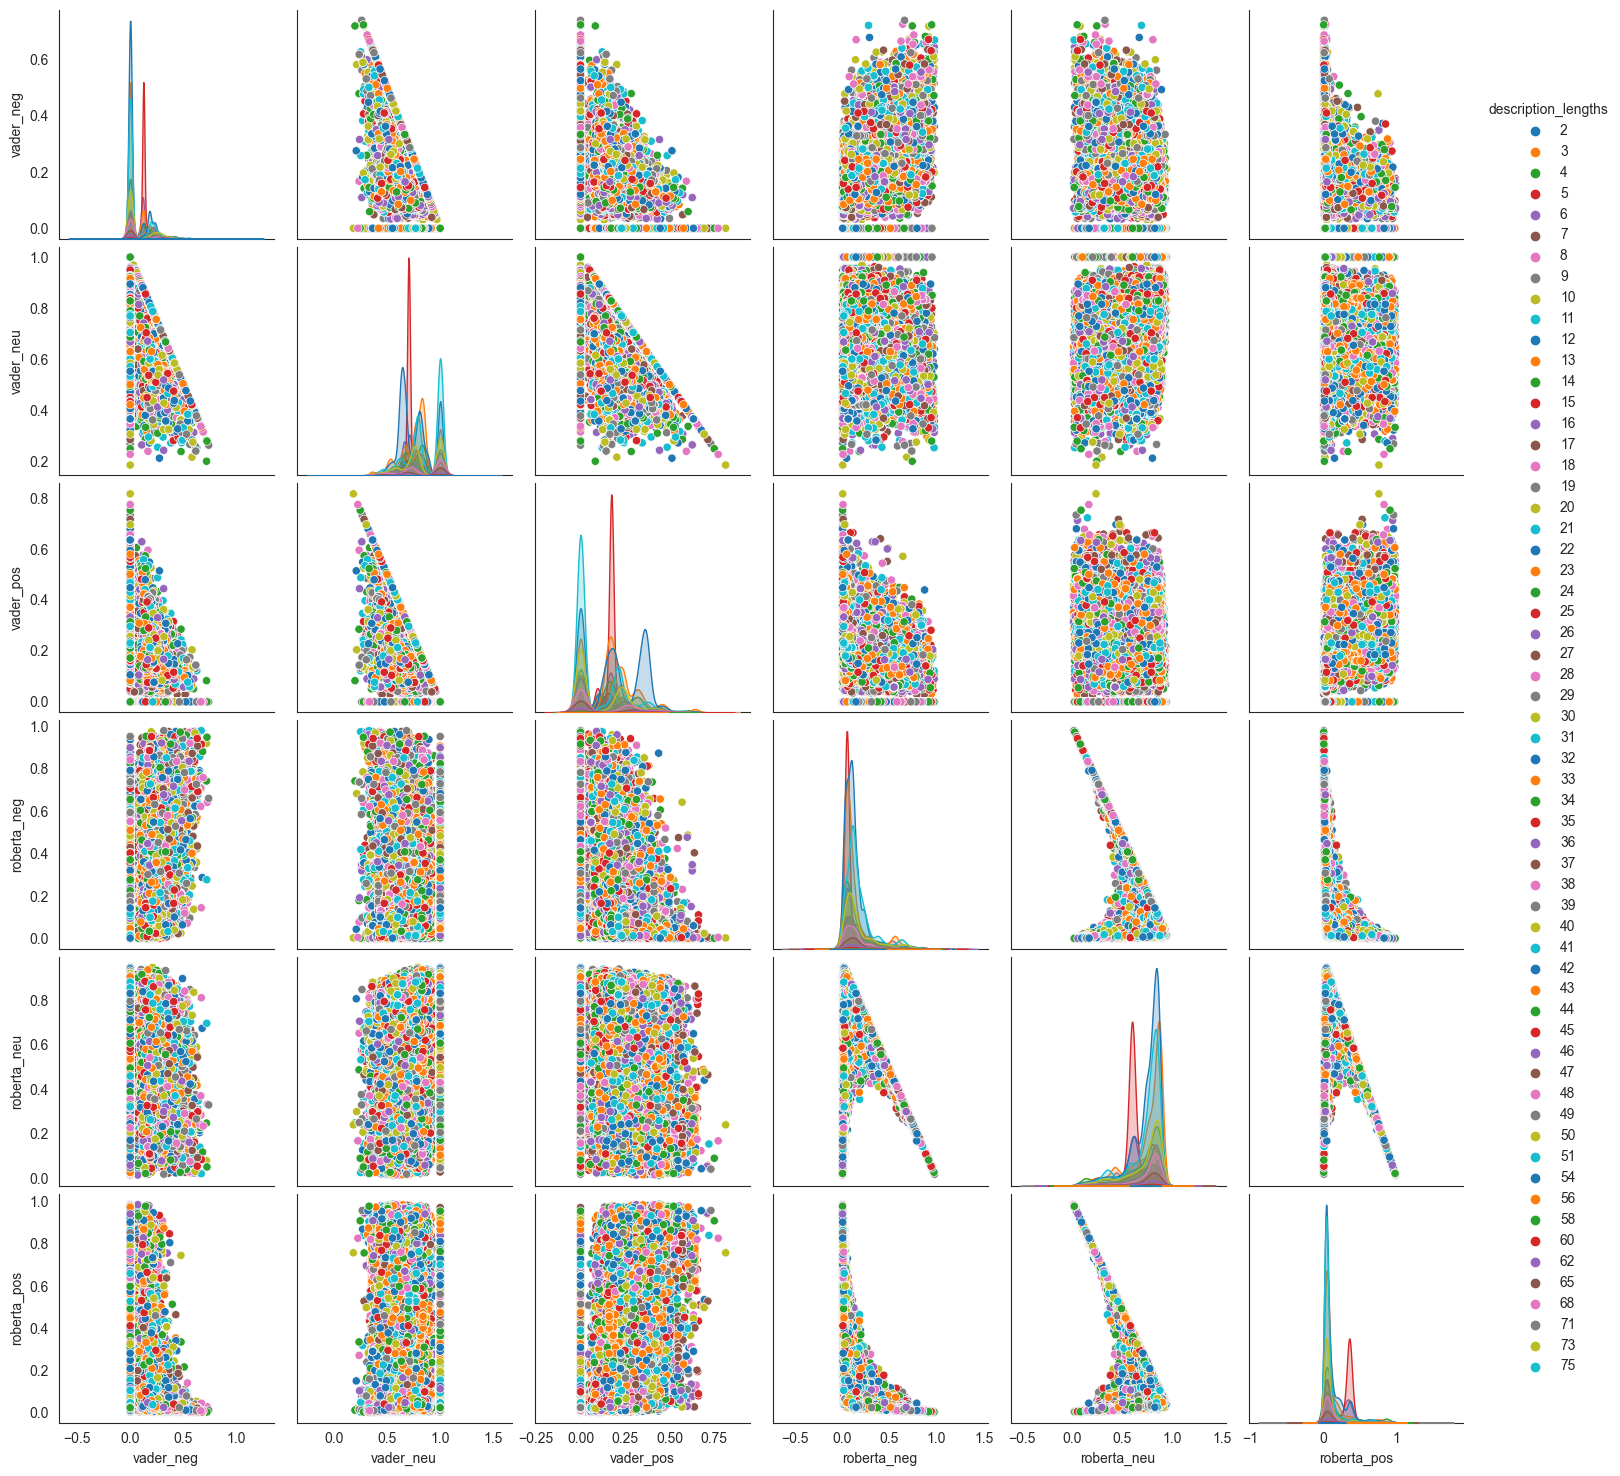

In [52]:
sns.pairplot(data=results_df, vars=['vader_neg', 'vader_neu', 'vader_pos', 'roberta_neg', 'roberta_neu', 'roberta_pos'], hue='description_lengths',
              palette='tab10')
plt.show()

In [ ]:
plt.figure(figsize=(12, 6))
sns.countplot(x='Sentiment', data=df)
plt.title('Sentiment Analysis Result on VADER model')